In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRFClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import optuna
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import backend as K



In [2]:
df = pd.read_csv("datasets/clustered.csv")

In [3]:
df["label_name"] = df["label_name"].str.lower()

In [4]:
df["text"] = df["text"].fillna("")

In [5]:
train_long = np.round(len(df) * 0.8)

In [6]:
train, test = df[:int(train_long)], df[int(train_long):]

In [7]:
y_train = LabelEncoder().fit_transform(train["label_name"])
y_test = LabelEncoder().fit_transform(test["label_name"])

In [8]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train["text"])
X_test = vectorizer.transform(test["text"])

In [9]:
joblib.dump(vectorizer, "models/vectorizer.pkl")

['models/vectorizer.pkl']

In [10]:
log_model = LogisticRegression()

In [11]:
log_model.fit(X_train, y_train)

cross_val_score(log_model, 
                X_train, 
                y_train,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.5085942101951861)

In [12]:
xgb_model = XGBRFClassifier()

In [13]:
xgb_model.fit(X_train, y_train)

cross_val_score(xgb_model,
                X_train,
                y_train,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.40585541497743965)

In [14]:
smote = SMOTE(sampling_strategy="auto", k_neighbors=3)

X_resampled, y_resambled = smote.fit_resample(X_train, y_train)

In [15]:
log_model.fit(X_resampled, y_resambled)

cross_val_score(log_model, 
                X_resampled, 
                y_resambled,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.7416076440296482)

In [16]:
xgb_model.fit(X_resampled, y_resambled)

cross_val_score(xgb_model,
                X_resampled,
                y_resambled,
                scoring="f1_macro",
                cv=5).mean()

np.float64(0.7163150685098623)

In [17]:
y_pred = log_model.predict(X_test)


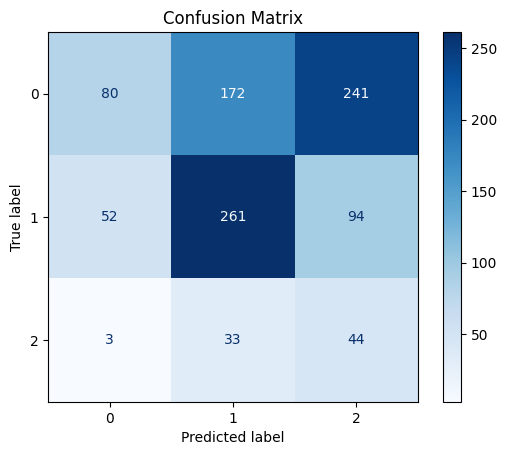

In [18]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

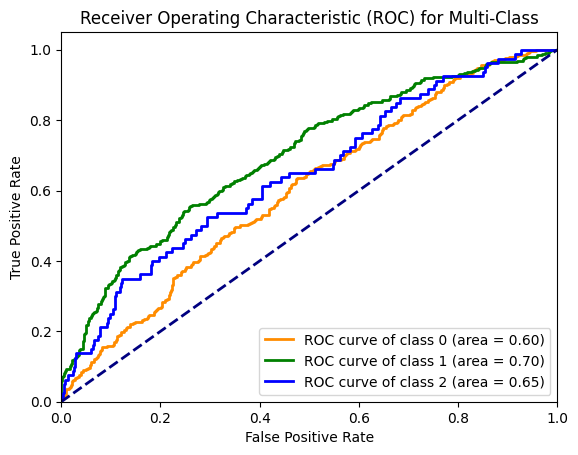

In [19]:
n_classes = 3


y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])


y_score = log_model.predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = ['darkorange', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [20]:
y_pred = xgb_model.predict(X_test)

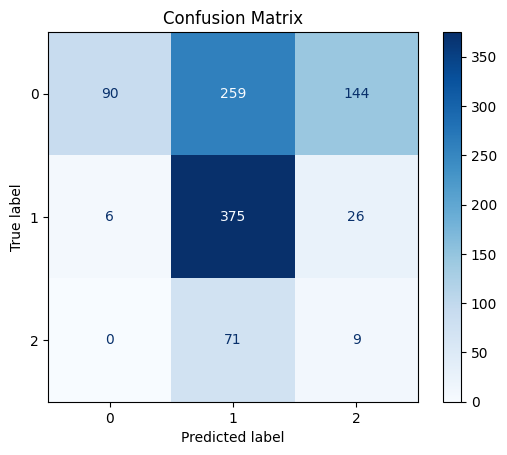

In [21]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

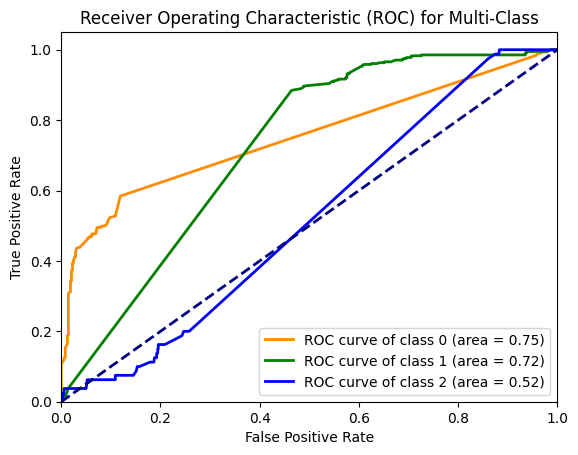

In [22]:
n_classes = 3


y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])


y_score = xgb_model.predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = ['darkorange', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [23]:
def objective(trial):
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    c = trial.suggest_loguniform('C', 1e-5, 1e2)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-2)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    
    model = LogisticRegression(
        C=c,
        penalty='l2',
        solver=solver,
        max_iter=max_iter,
        tol=tol,
        fit_intercept=fit_intercept,
        class_weight='balanced'
    )

    score = cross_val_score(model, X_resampled, y_resambled, scoring="f1_macro", cv=5).mean()

    return score

In [24]:
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=50)

[I 2024-11-09 13:23:41,426] A new study created in memory with name: no-name-c7a4f857-0697-4da5-bb68-c244017bf8c6
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_10708\3421442026.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  c = trial.suggest_loguniform('C', 1e-5, 1e2)
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_10708\3421442026.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-5, 1e-2)
c:\Users\MEHMET\Desktop\nlp_project\nlpenv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\MEHMET\Desktop\nlp_project\nlpenv\Li

In [25]:
print("Best Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)

Best Score: 0.7587906263351486
Best Hyperparameters: {'solver': 'liblinear', 'C': 0.8130645512699994, 'max_iter': 493, 'tol': 0.00043355394770071195, 'fit_intercept': False}


In [26]:
best_params = study.best_trial.params
best_model = LogisticRegression(**best_params, class_weight="balanced")
best_model.fit(X_resampled, y_resambled)

LogisticRegression(C=0.8130645512699994, class_weight='balanced',
                   fit_intercept=False, max_iter=493, solver='liblinear',
                   tol=0.00043355394770071195)

In [27]:
y_pred = best_model.predict(X_test)

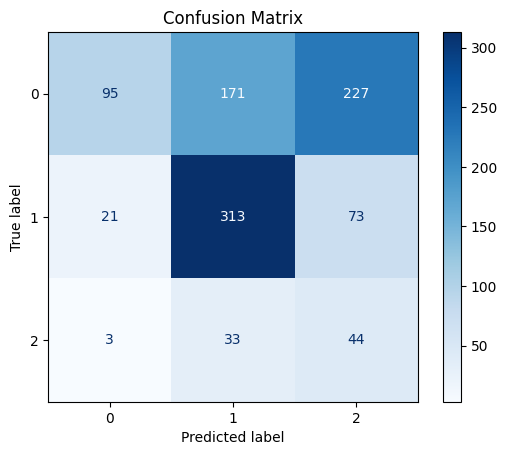

In [28]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

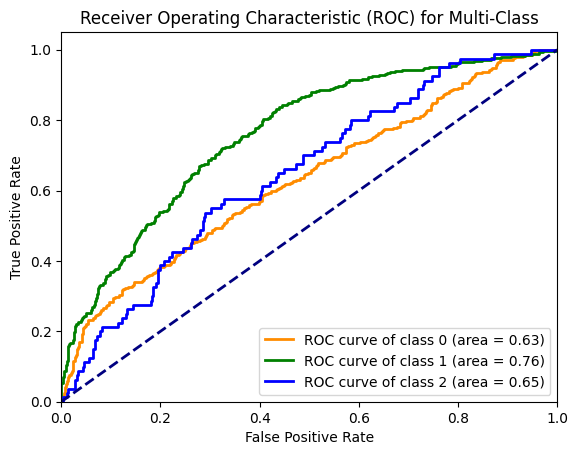

In [29]:
n_classes = 3


y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])


y_score = best_model.predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = ['darkorange', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [59]:
joblib.dump(best_model, "models/log_model.pkl")

['models/log_model.pkl']

In [60]:
def objective(trial):
    
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    
    model = XGBRFClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,  
        eval_metric="logloss"     
    )

    
    score = cross_val_score(model, X_resampled, y_resambled, scoring="f1_macro", cv=5).mean()

    return score

In [61]:
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=50)

[I 2024-11-09 14:06:31,514] A new study created in memory with name: no-name-70c48483-f11e-4dc8-bfdb-15c19acbca31
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_10708\848171552.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_10708\848171552.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
C:\Users\MEHMET\AppData\Local\Temp\ipykernel_10708\848171552.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

In [62]:
print("Best Score:", study.best_value)
print("Best Hyperparameters:", study.best_params)

Best Score: 0.8374106796557992
Best Hyperparameters: {'learning_rate': 0.01677052191460562, 'max_depth': 20, 'n_estimators': 598, 'subsample': 0.9912063387629875, 'colsample_bytree': 0.919087781866243}


In [ ]:
best_params = study.best_trial.params
best_xgb_model = XGBRFClassifier(**best_params)
best_xgb_model.fit(X_resampled, y_resambled)

c:\Users\MEHMET\Desktop\nlp_project\nlpenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                class_weight='balanced', colsample_bylevel=None,
                colsample_bytree=0.919087781866243, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.01677052191460562,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=20, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=598, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...)

In [64]:
y_pred = best_xgb_model.predict(X_test)

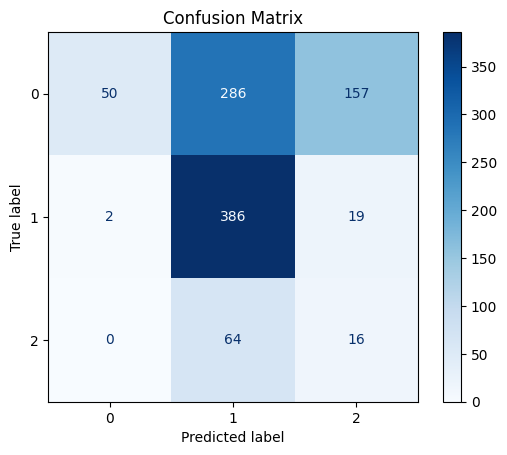

In [65]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

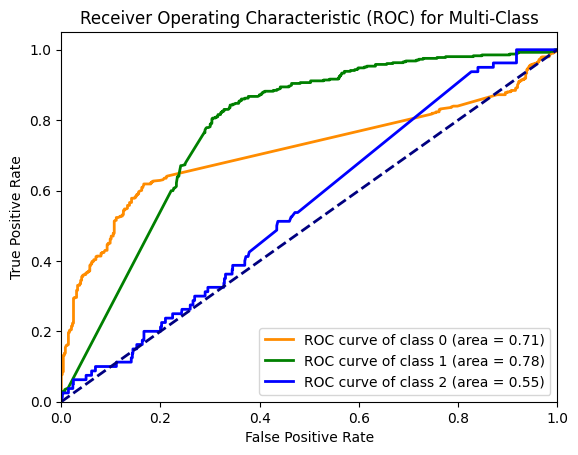

In [66]:
n_classes = 3


y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])


y_score = best_xgb_model.predict_proba(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = ['darkorange', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [67]:
joblib.dump(best_xgb_model, "models/xgb_model.pkl")

['models/xgb_model.pkl']

In [53]:
def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  
    y_pred = tf.round(y_pred)
    y_pred = K.cast(y_pred, 'float32')  
    
    tp = K.sum(K.cast(y_true * y_pred, 'float32'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

In [35]:
max_words = 10000
max_len = 100

In [38]:
X_trainn = train["text"]
X_testt = test["text"]

In [39]:
tokenizerr = Tokenizer(num_words=max_words)
tokenizerr.fit_on_texts(X_trainn)

In [40]:
X_train_seq = tokenizerr.texts_to_sequences(X_trainn)
X_test_seq = tokenizerr.texts_to_sequences(X_testt)

In [41]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [45]:
emmbedding_dim = 64

model = Sequential([
    Embedding(input_dim=max_words, output_dim=emmbedding_dim),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(3, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1_score])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [48]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [49]:
history = model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5490 - f1_score: 0.2125 - loss: 0.8652 - val_accuracy: 0.8662 - val_f1_score: 0.3136 - val_loss: 0.5617
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7517 - f1_score: 0.4900 - loss: 0.6063 - val_accuracy: 0.7631 - val_f1_score: 0.3139 - val_loss: 0.5806
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8761 - f1_score: 0.5921 - loss: 0.3731 - val_accuracy: 0.8064 - val_f1_score: 0.3283 - val_loss: 0.5236
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9209 - f1_score: 0.6282 - loss: 0.2613 - val_accuracy: 0.6803 - val_f1_score: 0.2991 - val_loss: 0.9244
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9468 - f1_score: 0.6661 - loss: 0.1965 - val_accuracy: 0.7414 - val_f1_score: 0.3045 - val_loss: 0.7396
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9635 - f1_score: 0.7355 - loss: 0.1337 - val_accuracy: 0.7452 - val_f1_score: 0.3200 - val

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


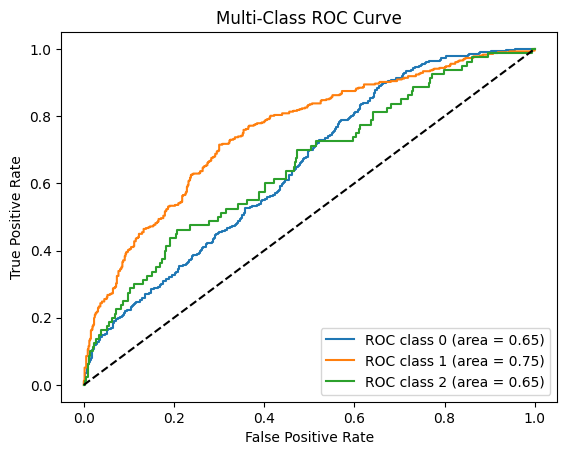

In [50]:
y_pred = model.predict(X_test_pad)
fpr, tpr, roc_auc = {}, {}, {}


for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [55]:
smote = SMOTE(sampling_strategy="auto", k_neighbors=3)

X_resampled_pad, y_resampled_cat = smote.fit_resample(X_train_pad, y_train_cat)

y_resampled_cat = y_resampled_cat.astype('float32')

In [56]:
history = model.fit(X_resampled_pad, y_resampled_cat, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6673 - f1_score: 0.6261 - loss: 0.8955 - val_accuracy: 0.2146 - val_f1_score: 0.0986 - val_loss: 2.5103
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8134 - f1_score: 0.8080 - loss: 0.4611 - val_accuracy: 0.2651 - val_f1_score: 0.1255 - val_loss: 2.8381
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8981 - f1_score: 0.8949 - loss: 0.2849 - val_accuracy: 0.2930 - val_f1_score: 0.1410 - val_loss: 3.0844
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9286 - f1_score: 0.9281 - loss: 0.2171 - val_accuracy: 0.2246 - val_f1_score: 0.1076 - val_loss: 4.2548
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9637 - f1_score: 0.9600 - loss: 0.1223 - val_accuracy: 0.2445 - val_f1_score: 0.1193 - val_loss: 4.2596
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9731 - f1_score: 0.9707 - loss: 0.0967 - val_accuracy: 0.2512 - val_f1_score: 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


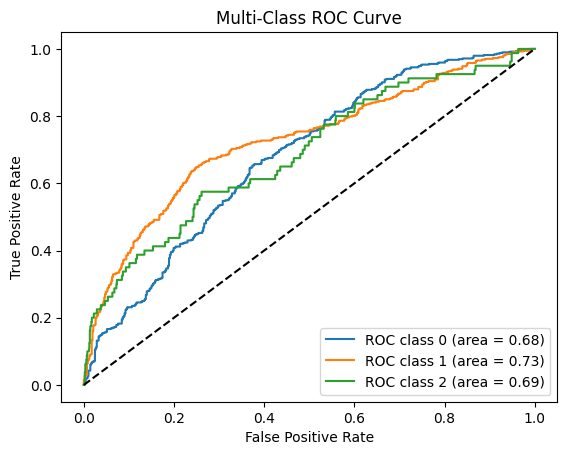

In [57]:
y_pred = model.predict(X_test_pad)
fpr, tpr, roc_auc = {}, {}, {}


for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [58]:
model.save("models/model.h5")